In [18]:
!pip install -qq tensorflow-datasets tensorflow matplotlib

In [19]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [20]:
# load the data from tfds
(train_ds, test_ds), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True,
)

In [21]:
ds_info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/home/martin/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

2023-11-20 12:47:43.496458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-11-20 12:47:43.496866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2023-11-20 12:47:43.547594: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline s

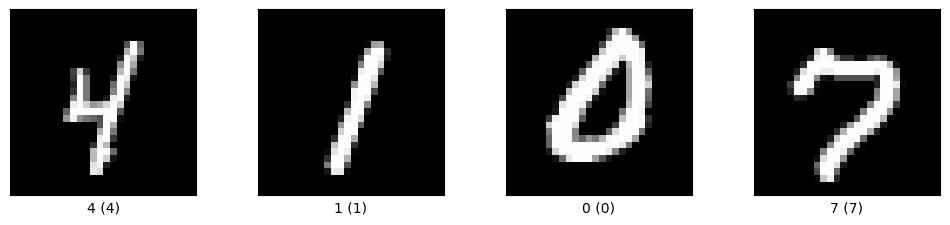

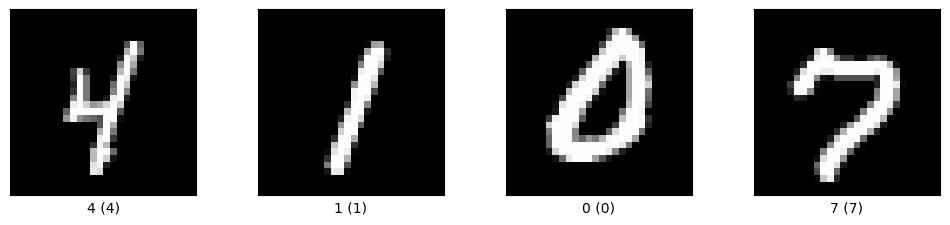

In [22]:
tfds.show_examples(train_ds, ds_info, rows=1, cols=4)

In [23]:
# data pipeline
def dataset(ds, mini_batch_size=512):
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32) / 128.0 - 1, y)) # normalize, 0~255 -> -1~1
    ds = ds.map(lambda x, y: (tf.reshape(x, (-1,)), y)) # flatten , 28x28 -> 784
    ds = ds.map(lambda x, y: (x, tf.one_hot(y, 10))) # one-hot encoding
    ds = ds.shuffle(10000).batch(mini_batch_size) # shuffle and batch
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE) # prefetch with AUTOTUNE for performance

    return ds

In [24]:
# # sanity check
# ds = dataset(train_ds)
# for elem in ds.take(1):
#     print(elem)

In [25]:
# simple model of feed-forward Dense layers
class Model(tf.keras.Model):
    """
    Create a simple feed-forward model with Dense layers.
    """
    def __init__(self, dense_layers, output_shape, layers_activation, output_activation):
        """
        args:
            dense_layers: list of int, number of neurons in each dense layer
            output_shape: int, number of neurons in the output layer
            layers_activation: str/activation function, activation function of the dense layers
            output_activation: str/activation function, activation function of the output layer
        """
        super(Model, self).__init__()
        self.__layers = []
        for layer in dense_layers:
            self.__layers.append(tf.keras.layers.Dense(layer, activation=layers_activation))
        self.__layers.append(tf.keras.layers.Dense(output_shape, activation=output_activation))

    def call(self, inputs):
        x = inputs
        for layer in self.__layers:
            x = layer(x)
        return x

In [26]:
from tqdm import tqdm

def training_loop(model, train, test, loss, opt, epochs=100):
    """
    Train the model with the given training and test datasets.
    args:
        model: tf.keras.Model, the model to train
        train: tf.data.Dataset, the training dataset
        test: tf.data.Dataset, the test dataset
        loss: tf.keras.losses, the loss function
        opt: tf.keras.optimizers, the optimizer
        epochs: int, number of epochs to train
    return:
        metrics: dict, training and test metrics
    """
    train_loss = tf.keras.metrics.Mean()
    train_accuracy = tf.keras.metrics.CategoricalAccuracy()
    test_loss = tf.keras.metrics.Mean()
    test_accuracy = tf.keras.metrics.CategoricalAccuracy()

    metrics = {
        'train_loss': [],
        'train_accuracy': [],
        'test_loss': [],
        'test_accuracy': [],
    }

    for epoch in tqdm(range(epochs), desc='Epochs'):
        for x, y in train:
            with tf.GradientTape() as tape:
                y_pred = model(x)
                loss_value = loss(y, y_pred)
            grads = tape.gradient(loss_value, model.trainable_variables)
            opt.apply_gradients(zip(grads, model.trainable_variables))
            
            train_loss(loss_value)
            train_accuracy(y, y_pred)
        
        for x, y in test:
            y_pred = model(x)
            loss_value = loss(y, y_pred)
            
            test_loss(loss_value)
            test_accuracy(y, y_pred)

        metrics['train_loss'].append(train_loss.result().numpy())
        metrics['train_accuracy'].append(train_accuracy.result().numpy())
        metrics['test_loss'].append(test_loss.result().numpy())
        metrics['test_accuracy'].append(test_accuracy.result().numpy())

        print(f'Train Loss: {metrics["train_loss"][-1]:.4f}, Train Accuracy: {metrics["train_accuracy"][-1]:.4f}')
        print(f'Test Loss: {metrics["test_loss"][-1]:.4f}, Test Accuracy: {metrics["test_accuracy"][-1]:.4f}')
        print()

    return metrics


In [46]:
# plotting, saving and loading metrics
import matplotlib.pyplot as plt
import numpy as np
import json
import os

def save_model_info(file_name, model_info):
    """
    Save the model info to a json file.
    args:
        file_name: str, name of the json file
        model_info: dict, model info
    """
    directory = os.path.dirname(file_name)
    if not os.path.exists(directory):
        os.makedirs(directory)

    with open(file_name, 'w') as f:
        json.dump(model_info, f)

def save_metrics(model, metrics, hyper_parameter, model_type,file_name='metrics.json', model_description=""):
    """
    Save the metrics of the model to a json file.
    args:
        model: tf.keras.Model, the model to train
        metrics: dict, training and test metrics
        hyper_parameter: dict, hyper parameter of the model
        type: str, type of the model
        file_name: str, name of the json file
    """
    # round the measurmenrs to 4 decimal places
    for key, value in metrics.items():
        metrics[key] = [np.around(float(x), 4) for x in value]
    
    # add the number of parameters to the metrics
    params = model.count_params()

    # initialize the model info dict
    model_info = {
                "description": model_description ,
                "type": model_type,
                "parameter_count": params,
                "hyper_parameter": hyper_parameter,
                "metrics": metrics,
                "accuracy_test": metrics['test_accuracy'][-1],
                "accuracy_train": metrics['train_accuracy'][-1],
                "loss_test": metrics['test_loss'][-1],
                "loss_train": metrics['train_loss'][-1],
                }
    
    # save the model info to a json file
    save_model_info(file_name, model_info)

def load_metrics(file_name='metrics.json'):
    """
    Load the metrics of the model from a json file.
    """
    with open(file_name, 'r') as f:
        model_info = json.load(f)
    return model_info
    

def visualize(metrics, fig_title = "",max_steps = 20):

    # set the x-axis ticks
    epoch_idx = range(1,len(metrics['test_loss']) + 1)
    x_ticks = list(epoch_idx)
    x_ticks = x_ticks[::len(x_ticks)//max_steps + 1]

    # Create a figure with two subplots (axes)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(fig_title)

    # Plot test loss and accuracy
    line3, = ax1.plot(epoch_idx, metrics['test_loss'], 'r-')
    line4, = ax1.plot(epoch_idx, metrics['train_loss'], 'b-')

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend([line3, line4], ['Test Loss', 'Train Loss'])
    ax1.set_title('Loss, Train - Test')
    ax1.set_xticks(x_ticks)
    ax1.grid(True)

    # Plot training loss and accuracy
    line1, = ax2.plot(epoch_idx, metrics['test_accuracy'], 'r--')
    line2, = ax2.plot(epoch_idx, metrics['train_accuracy'], 'b--')

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend([line1, line2], ['Test Accuracy', 'Train Accuracy'])
    ax2.set_title('Accuracy, Train - Test')
    ax2.set_xticks(x_ticks)
    ax2.grid(True)

    # Show the plots
    plt.tight_layout()
    plt.show()


def plot_model_comparision(models:list, max_steps = 20):
    """
    Plot the test accuracy of the given models.
    """
    fig , ax = plt.subplots(1, 1, figsize=(10, 10))
    fig.suptitle("Model Comparision")

    # set the x-axis ticks
    
    metrics_lenght = len(load_metrics(models[0])['metrics']['test_loss'])
    epoch_idx = range(1,metrics_lenght + 1)
    x_ticks = list(epoch_idx)
    x_ticks = x_ticks[::len(x_ticks)//max_steps + 1]

    for model in models:
        model_info = load_metrics(model)
        model_metrics = model_info['metrics']
        model_hyper_parameter = model_info['hyper_parameter']
        label = f"{model_info['type']}_{len(model_hyper_parameter['DENSE_LAYERS'])}: {model_info['parameter_count']:,}"
        ax.plot(epoch_idx, model_metrics['test_accuracy'], label=label)

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title('Test Accuracy')
    ax.set_xticks(x_ticks)
    ax.grid(True)
    ax.legend()

    plt.tight_layout()
    plt.show()

### Hyperparameters

In [28]:
class Model_Convolve(tf.keras.Model):
    """
    a simple CNN model with 2 Conv2D layers and 2 MaxPooling2D layers
    """
    def __init__(self):
        super(Model_Convolve, self).__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Conv2D(8, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1)),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(16, kernel_size=(5, 5), activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax'),
        ])

    def call(self, inputs):
        x = tf.reshape(inputs, [-1, 28, 28, 1])
        return self.seq(x)

In [29]:
# configuration of the hyper parameters
DENSE_LAYERS = [16,16]
EPOCHS = 10
BATCH_SIZE = 128
LEARNING_RATE = 0.001
MOMENTUM = 0.9
USE_SCHEDULER = True
OPTIMIZER = "SGD"

TYPE = 'dense' # dense or conv

train_data = dataset(train_ds, BATCH_SIZE)
test_data = dataset(test_ds, BATCH_SIZE)

In [30]:
# initialize the model
if TYPE == 'dense':
    model = Model(DENSE_LAYERS, 10, 'relu', 'softmax')
elif TYPE == 'conv':
    model = Model_Convolve()

loss = tf.keras.losses.CategoricalCrossentropy()
if USE_SCHEDULER:
    lr_fn = tf.optimizers.schedules.PolynomialDecay(LEARNING_RATE*0.1, EPOCHS, LEARNING_RATE*10, 2) # use a scheduler to decay the learning rate over time
    if OPTIMIZER == "SGD":
        opt = tf.keras.optimizers.SGD(learning_rate=lr_fn, momentum=MOMENTUM)
    elif OPTIMIZER == "Adam":
        opt = tf.keras.optimizers.Adam(learning_rate=lr_fn)
else:
    if OPTIMIZER == "SGD":
        opt = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM)
    elif OPTIMIZER == "Adam":
        opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

In [31]:
# train the modle and get the metrics of the training
metrics = training_loop(model, train_data, test_data, loss, opt, EPOCHS)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

2023-11-20 12:47:43.970954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-11-20 12:47:43.971616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-11-20 12:47:51.206313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{nod

Train Loss: 0.5742, Train Accuracy: 0.8163
Test Loss: 0.3215, Test Accuracy: 0.9047



Epochs:  20%|██        | 2/10 [00:15<01:01,  7.71s/it]

Train Loss: 0.4406, Train Accuracy: 0.8625
Test Loss: 0.2890, Test Accuracy: 0.9157



Epochs:  30%|███       | 3/10 [00:22<00:52,  7.48s/it]

Train Loss: 0.3824, Train Accuracy: 0.8818
Test Loss: 0.2846, Test Accuracy: 0.9148



Epochs:  40%|████      | 4/10 [00:29<00:43,  7.25s/it]

Train Loss: 0.3479, Train Accuracy: 0.8931
Test Loss: 0.2741, Test Accuracy: 0.9170



Epochs:  50%|█████     | 5/10 [00:36<00:36,  7.20s/it]

Train Loss: 0.3230, Train Accuracy: 0.9012
Test Loss: 0.2609, Test Accuracy: 0.9210



Epochs:  60%|██████    | 6/10 [00:43<00:28,  7.12s/it]

Train Loss: 0.3036, Train Accuracy: 0.9072
Test Loss: 0.2528, Test Accuracy: 0.9235



Epochs:  70%|███████   | 7/10 [00:51<00:21,  7.21s/it]

Train Loss: 0.2881, Train Accuracy: 0.9121
Test Loss: 0.2457, Test Accuracy: 0.9259



Epochs:  80%|████████  | 8/10 [00:58<00:14,  7.21s/it]

Train Loss: 0.2757, Train Accuracy: 0.9160
Test Loss: 0.2399, Test Accuracy: 0.9275



Epochs:  90%|█████████ | 9/10 [01:05<00:07,  7.18s/it]

Train Loss: 0.2652, Train Accuracy: 0.9194
Test Loss: 0.2338, Test Accuracy: 0.9296



Epochs: 100%|██████████| 10/10 [01:12<00:00,  7.29s/it]

Train Loss: 0.2562, Train Accuracy: 0.9223
Test Loss: 0.2303, Test Accuracy: 0.9306



In [32]:
# save the metrics and model meta data to a json file
hyper_parameter = {
    'DENSE_LAYERS': DENSE_LAYERS,
    'EPOCHS': EPOCHS,
    'BATCH_SIZE': BATCH_SIZE,
    'LEARNING_RATE': LEARNING_RATE,
    'MOMENTUM': MOMENTUM,
    'USE_SCHEDULER': USE_SCHEDULER,
    'OPTIMIZER': OPTIMIZER
}

file_name = f'./epochs_{EPOCHS}/' + 'metrics_12.json'
save_metrics(model, metrics, hyper_parameter, TYPE, file_name)

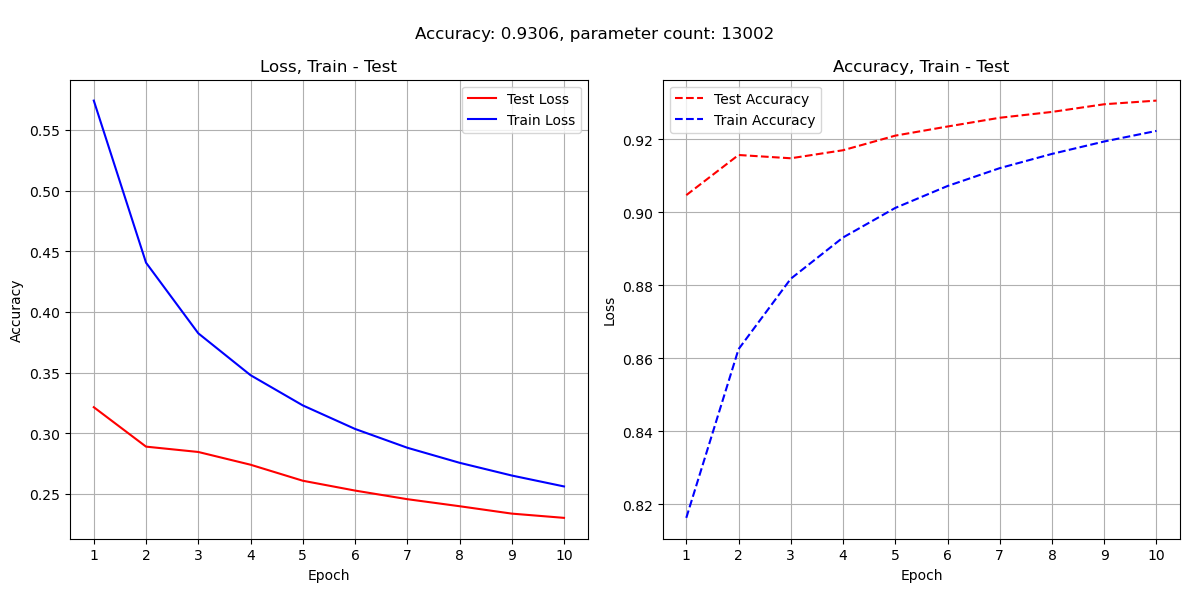

In [33]:
# visualize the metrics

# file_name = "./epochs_10/metrics_12.json"
with open(file_name, 'r') as f:
    model_info = json.load(f)

visualize(model_info['metrics'],
 f"{model_info['description']}\nAccuracy: {model_info['accuracy_test']:.4f}, parameter count: {model_info['parameter_count']}") # visualize the metrics with title from a json file

# visualize(metrics) # direct visualization from the metrics dict


In [34]:
# compare multiple models from json files both tabularly and graphically
import pandas as pd

def compare_models(models_to_compare, plot=True):


    # Define columns for the DataFrame
    columns = ['model', 'layers', '#params', 'lr', 'momentum', 'mini_batch', 'epochs', 'optimizer', 'accuracy_test', 'accuracy_train']
    df = pd.DataFrame(columns=columns)

    for model in models_to_compare:
        model_info = load_metrics(model)
        model_hyper_parameter = model_info['hyper_parameter']

        # Create a new entry as a dictionary ensuring all columns are covered
        new_entry = {
            'model': model_info['description'],
            'layers': model_hyper_parameter.get('DENSE_LAYERS', pd.NA),  # Using pd.NA for missing values
            '#params': model_info['parameter_count'],
            'lr': model_hyper_parameter.get('LEARNING_RATE', pd.NA),
            'momentum': model_hyper_parameter.get('MOMENTUM', pd.NA),
            'mini_batch': model_hyper_parameter.get('BATCH_SIZE', pd.NA),
            'epochs': model_hyper_parameter.get('EPOCHS', pd.NA),
            'optimizer': model_hyper_parameter.get('OPTIMIZER', pd.NA),
            'accuracy_test': model_info.get('accuracy_test', pd.NA),
            'accuracy_train': model_info.get('accuracy_train', pd.NA)
        }

        # Convert the dictionary to a DataFrame and concatenate
        new_entry_df = pd.DataFrame([new_entry], columns=columns)
        df = pd.concat([df, new_entry_df], ignore_index=True)

    df = df.sort_values(by=['accuracy_test'], ascending=False)
    # print(df.to_string())

    if plot:
        plot_model_comparision(models_to_compare)

    return df

In [48]:
# models to consider for the comparision
MODELS_IDX = [0,4,7,6,10]

/tmp/ipykernel_7906/1170558275.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_entry_df], ignore_index=True)


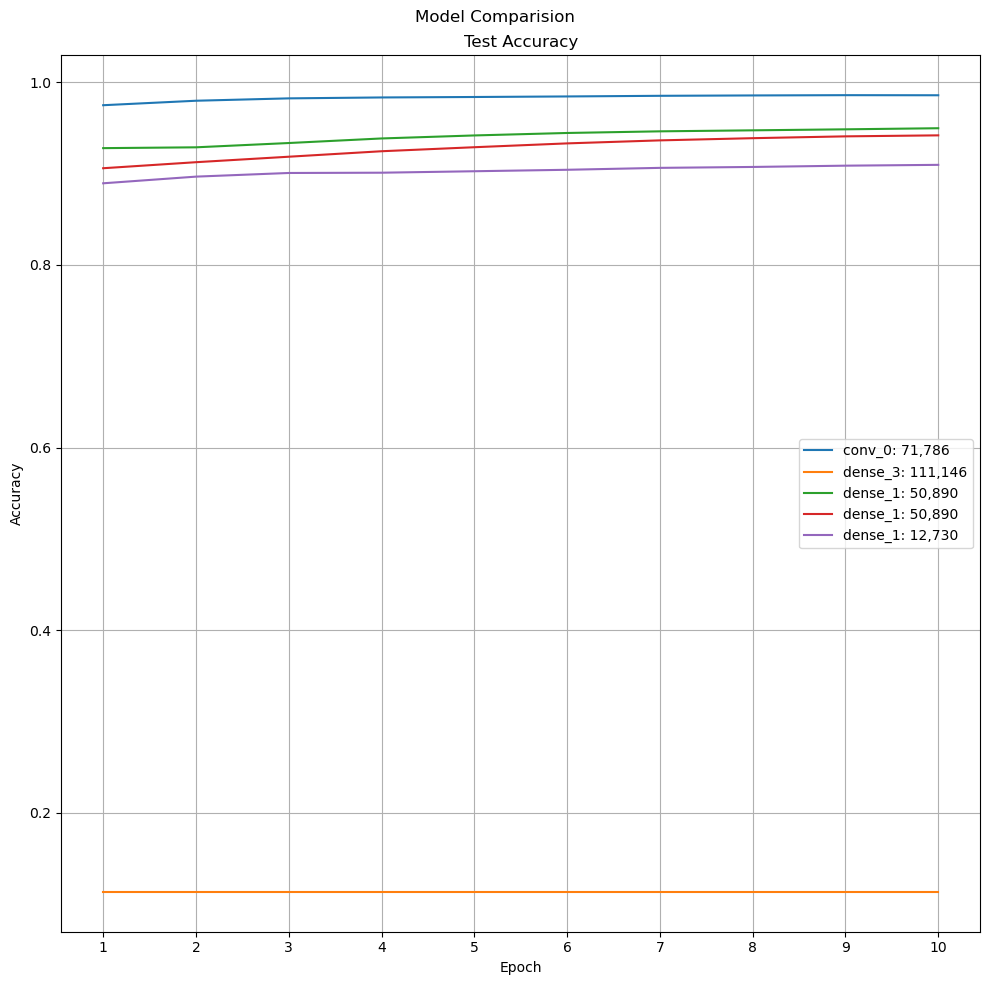

,model,layers,#params,lr,momentum,mini_batch,epochs,optimizer,accuracy_test,accuracy_train
0,CNN_2Conv_2MaxPool_1Dense,[],71786,0.010,0.9,512,10,Adam,0.9858,0.9825
2,Dense_1,[64],50890,0.010,0.5,128,10,SGD,0.9497,0.9434
3,Dense_1,[64],50890,0.010,0.5,256,10,SGD,0.9419,0.9379
4,Dense_1,[16],12730,0.001,0.9,64,10,Adam,0.9096,0.9031
1,Dense_3,"[128, 64, 32]",111146,0.010,0.9,512,10,SGD,0.1135,0.1203


In [60]:
models_path = "./epochs_10/"
models_files = ["metrics_00.json","metrics_01.json",
                    "metrics_02.json", "metrics_03.json",
                    "metrics_04.json", "metrics_05.json",
                    "metrics_06.json", "metrics_07.json",
                    "metrics_08.json", "metrics_09.json",
                    "metrics_10.json", "metrics_11.json"]
models_files = [models_files[i] for i in MODELS_IDX]

models_to_compare = [models_path + model for model in models_files] # add the path to the models
df = compare_models(models_to_compare, plot=True)
df

### analysis of the results
for the analysis we will briefly discuss the results of the following 4 DenseNet models and the best performing model (CNN):
-All models were trained for 10 epochs

- A - Denes - [64] neurons - LR: 0.01 - momentum: 0.5 - batch size: 128 - opt: SGD - params: 50890   
- B - Dense - [64] neurons - LR: 0.01 - momentum: 0.5 - batch size: 256 - opt: SGD - params: 50890   
- C - Dense - [16] neurons - LR: 0.001 - momentum: 0.9 - batch size: 64 - opt: Adam - params: 12730   
- D - Dense - [128, 64, 32] neurons - LR: 0.01 - momentum: 0.9 - batch size: 256 - opt: SGD - params: 111146  

- model A has performed better than larger models and same models with varient RL and momentum ( B and D and other similar ones) what sat it apart was the smaller batch size, which allowed for more frequent updates to the weights, where as model D proved to be too large for the learning rate of 0.01 on the given task, and could not converge at all, model C of only one hidden layer of 16 neurons proved to perform comparaply well with over 90% accuracy, and smaller batches proved better than larger ones, as well as smaller LR and higher momentum.

the closest we got to a CNN performance (98.5%) was with model A (95%), and next with condedirably larger moodels not included in the anaylsis above, [256, 128, 256] with (96.7%) ...

## --- IGNORE BELOW ---- 


In [61]:
MODELS_IDX = [0,4,7,6,10]

adjust hyper parameter across moduls:

In [15]:
def train_from_json(file_name, **override_hyper_parameter):
    """
    Load the model from a json file and optionally override the hyper parameters
    args:
        file_name: str, name of the json file
        override_hyper_parameter: dict, hyper parameters to override
    return:
        model: tf.keras.Model, the model to train
        train_data: tf.data.Dataset, the training dataset
        test_data: tf.data.Dataset, the test dataset
        hyper_parameter: dict, hyper parameter of the model
    """
    with open(file_name, 'r') as f:
        model_info = json.load(f)
    
    hyper_parameter = model_info['hyper_parameter']
    hyper_parameter.update(override_hyper_parameter)

    if model_info['description'].startswith('Dense'):
        model = Model(hyper_parameter['DENSE_LAYERS'], 10, 'relu', 'softmax')
    elif model_info['description'].startswith('CNN'):
        model = Model_Convolve()
 
    loss = tf.keras.losses.CategoricalCrossentropy()
    if hyper_parameter['USE_SCHEDULER']:
        lr_fn = tf.optimizers.schedules.PolynomialDecay(hyper_parameter['LEARNING_RATE']*0.1, hyper_parameter['EPOCHS'], hyper_parameter['LEARNING_RATE']*10, 2) # use a scheduler to decay the learning rate over time
        if hyper_parameter['OPTIMIZER'] == 'Adam':
            opt = tf.keras.optimizers.Adam(learning_rate=lr_fn)
        else:
            opt = tf.keras.optimizers.SGD(learning_rate=lr_fn, momentum=hyper_parameter['MOMENTUM'])
    else:
        if hyper_parameter['OPTIMIZER'] == 'Adam':
            opt = tf.keras.optimizers.Adam(learning_rate=hyper_parameter['LEARNING_RATE'])
        else:
            opt = tf.keras.optimizers.SGD(learning_rate=hyper_parameter['LEARNING_RATE'], momentum=hyper_parameter['MOMENTUM'])
    
    train_data = dataset(train_ds, hyper_parameter['BATCH_SIZE'])
    test_data = dataset(test_ds, hyper_parameter['BATCH_SIZE'])

    # build the model

    metrics = training_loop(model, train_data, test_data, loss, opt, hyper_parameter['EPOCHS'])
    
    for key, value in metrics.items():
        metrics[key] = [np.around(float(x), 4) for x in value]

    model_info['metrics'] = metrics
    model_info['hyper_parameter'] = hyper_parameter

    model_info['accuracy_test'] = metrics['test_accuracy'][-1]
    model_info['accuracy_train'] = metrics['train_accuracy'][-1]
    model_info['loss_test'] = metrics['test_loss'][-1]
    model_info['loss_train'] = metrics['train_loss'][-1]

    model_info['parameter_count'] = model.count_params()

    return model_info


set some hypermeter you want to change/unify across moduls

In [71]:

# run already saved models for x epochs
NEW_EPOCHS = 20
new_USE_SCHEDULER = False

models_path = "./epochs_10/"
models_files = ["metrics_00.json","metrics_01.json",
                    "metrics_02.json", "metrics_03.json",
                    "metrics_04.json", "metrics_05.json",
                    "metrics_06.json", "metrics_07.json",
                    "metrics_08.json", "metrics_09.json",
                    "metrics_10.json", "metrics_11.json"]

# models_files = [models_files[i] for i in MODELS_IDX + [1]]
models_files = [models_files[i] for i in range(len(models_files)) if i not in MODELS_IDX + [1]]

models_to_compare = [models_path + model for model in models_files] # add the path to the models

new_models_path = f"./epochs_{NEW_EPOCHS}/" if new_USE_SCHEDULER else f"./epochs_{NEW_EPOCHS}_no_scheduler/"
                 
for idx, model_file in enumerate(models_to_compare):

    new_model_info = train_from_json(model_file, EPOCHS=NEW_EPOCHS, USE_SCHEDULER=new_USE_SCHEDULER)
     
    new_model_file = new_models_path + models_files[idx]
    save_model_info(new_model_file, new_model_info)


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]2023-11-20 13:46:52.774725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-11-20 13:46:52.775302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-11-20 13:46:55.792619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholde

Train Loss: 1.8899, Train Accuracy: 0.3841
Test Loss: 1.3037, Test Accuracy: 0.6723



Epochs:  10%|█         | 2/20 [00:06<00:57,  3.18s/it]

Train Loss: 1.4206, Train Accuracy: 0.5701
Test Loss: 0.9882, Test Accuracy: 0.7485



Epochs:  15%|█▌        | 3/20 [00:09<00:52,  3.08s/it]

Train Loss: 1.1461, Train Accuracy: 0.6588
Test Loss: 0.8255, Test Accuracy: 0.7863



Epochs:  20%|██        | 4/20 [00:12<00:48,  3.02s/it]

Train Loss: 0.9799, Train Accuracy: 0.7098
Test Loss: 0.7262, Test Accuracy: 0.8106



Epochs:  25%|██▌       | 5/20 [00:15<00:44,  2.98s/it]

Train Loss: 0.8684, Train Accuracy: 0.7434
Test Loss: 0.6580, Test Accuracy: 0.8270



Epochs:  30%|███       | 6/20 [00:18<00:41,  2.97s/it]

Train Loss: 0.7881, Train Accuracy: 0.7674
Test Loss: 0.6080, Test Accuracy: 0.8390



Epochs:  35%|███▌      | 7/20 [00:21<00:38,  2.96s/it]

Train Loss: 0.7275, Train Accuracy: 0.7855
Test Loss: 0.5691, Test Accuracy: 0.8480



Epochs:  40%|████      | 8/20 [00:24<00:35,  2.96s/it]

Train Loss: 0.6796, Train Accuracy: 0.7997
Test Loss: 0.5383, Test Accuracy: 0.8552



Epochs:  45%|████▌     | 9/20 [00:27<00:32,  2.95s/it]

Train Loss: 0.6408, Train Accuracy: 0.8111
Test Loss: 0.5135, Test Accuracy: 0.8610



Epochs:  50%|█████     | 10/20 [00:29<00:29,  2.96s/it]

Train Loss: 0.6085, Train Accuracy: 0.8207
Test Loss: 0.4921, Test Accuracy: 0.8663



Epochs:  55%|█████▌    | 11/20 [00:32<00:26,  2.95s/it]

Train Loss: 0.5812, Train Accuracy: 0.8288
Test Loss: 0.4738, Test Accuracy: 0.8706



Epochs:  60%|██████    | 12/20 [00:35<00:23,  2.95s/it]

Train Loss: 0.5576, Train Accuracy: 0.8358
Test Loss: 0.4578, Test Accuracy: 0.8745



Epochs:  65%|██████▌   | 13/20 [00:38<00:20,  2.96s/it]

Train Loss: 0.5371, Train Accuracy: 0.8419
Test Loss: 0.4440, Test Accuracy: 0.8778



Epochs:  70%|███████   | 14/20 [00:41<00:17,  2.96s/it]

Train Loss: 0.5189, Train Accuracy: 0.8473
Test Loss: 0.4318, Test Accuracy: 0.8810



Epochs:  75%|███████▌  | 15/20 [00:44<00:14,  2.96s/it]

Train Loss: 0.5027, Train Accuracy: 0.8521
Test Loss: 0.4206, Test Accuracy: 0.8838



Epochs:  80%|████████  | 16/20 [00:47<00:11,  2.96s/it]

Train Loss: 0.4881, Train Accuracy: 0.8564
Test Loss: 0.4105, Test Accuracy: 0.8863



Epochs:  85%|████████▌ | 17/20 [00:50<00:08,  2.96s/it]

Train Loss: 0.4749, Train Accuracy: 0.8604
Test Loss: 0.4013, Test Accuracy: 0.8887



Epochs:  90%|█████████ | 18/20 [00:53<00:05,  2.96s/it]

Train Loss: 0.4628, Train Accuracy: 0.8640
Test Loss: 0.3930, Test Accuracy: 0.8908



Epochs:  95%|█████████▌| 19/20 [00:56<00:02,  2.95s/it]

Train Loss: 0.4517, Train Accuracy: 0.8673
Test Loss: 0.3852, Test Accuracy: 0.8928



Epochs: 100%|██████████| 20/20 [00:59<00:00,  2.98s/it]


Train Loss: 0.4414, Train Accuracy: 0.8703
Test Loss: 0.3782, Test Accuracy: 0.8945



Epochs:   0%|          | 0/20 [00:00<?, ?it/s]2023-11-20 13:47:52.357992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2023-11-20 13:47:52.358657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2023-11-20 13:47:55.568359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placehold

Train Loss: 0.5053, Train Accuracy: 0.8453
Test Loss: 0.3052, Test Accuracy: 0.9163



Epochs:  10%|█         | 2/20 [00:07<01:05,  3.66s/it]

Train Loss: 0.4018, Train Accuracy: 0.8788
Test Loss: 0.2856, Test Accuracy: 0.9202



Epochs:  15%|█▌        | 3/20 [00:10<01:01,  3.63s/it]

Train Loss: 0.3531, Train Accuracy: 0.8942
Test Loss: 0.2697, Test Accuracy: 0.9242



Epochs:  20%|██        | 4/20 [00:14<00:57,  3.62s/it]

Train Loss: 0.3212, Train Accuracy: 0.9046
Test Loss: 0.2548, Test Accuracy: 0.9275



Epochs:  25%|██▌       | 5/20 [00:18<00:54,  3.61s/it]

Train Loss: 0.2970, Train Accuracy: 0.9123
Test Loss: 0.2422, Test Accuracy: 0.9308



Epochs:  30%|███       | 6/20 [00:21<00:50,  3.63s/it]

Train Loss: 0.2777, Train Accuracy: 0.9183
Test Loss: 0.2320, Test Accuracy: 0.9339



Epochs:  35%|███▌      | 7/20 [00:25<00:47,  3.63s/it]

Train Loss: 0.2618, Train Accuracy: 0.9232
Test Loss: 0.2219, Test Accuracy: 0.9368



Epochs:  40%|████      | 8/20 [00:29<00:43,  3.64s/it]

Train Loss: 0.2483, Train Accuracy: 0.9273
Test Loss: 0.2130, Test Accuracy: 0.9391



Epochs:  45%|████▌     | 9/20 [00:32<00:40,  3.64s/it]

Train Loss: 0.2365, Train Accuracy: 0.9308
Test Loss: 0.2051, Test Accuracy: 0.9412



Epochs:  50%|█████     | 10/20 [00:36<00:37,  3.71s/it]

Train Loss: 0.2262, Train Accuracy: 0.9338
Test Loss: 0.1984, Test Accuracy: 0.9429



Epochs:  55%|█████▌    | 11/20 [00:40<00:33,  3.68s/it]

Train Loss: 0.2170, Train Accuracy: 0.9365
Test Loss: 0.1922, Test Accuracy: 0.9446



Epochs:  60%|██████    | 12/20 [00:43<00:29,  3.68s/it]

Train Loss: 0.2088, Train Accuracy: 0.9389
Test Loss: 0.1866, Test Accuracy: 0.9460



Epochs:  65%|██████▌   | 13/20 [00:47<00:25,  3.67s/it]

Train Loss: 0.2013, Train Accuracy: 0.9411
Test Loss: 0.1820, Test Accuracy: 0.9473



Epochs:  70%|███████   | 14/20 [00:51<00:22,  3.68s/it]

Train Loss: 0.1945, Train Accuracy: 0.9431
Test Loss: 0.1773, Test Accuracy: 0.9485



Epochs:  75%|███████▌  | 15/20 [00:54<00:18,  3.66s/it]

Train Loss: 0.1883, Train Accuracy: 0.9449
Test Loss: 0.1732, Test Accuracy: 0.9496



Epochs:  80%|████████  | 16/20 [00:58<00:14,  3.65s/it]

Train Loss: 0.1826, Train Accuracy: 0.9466
Test Loss: 0.1698, Test Accuracy: 0.9505



Epochs:  85%|████████▌ | 17/20 [01:02<00:10,  3.66s/it]

Train Loss: 0.1772, Train Accuracy: 0.9482
Test Loss: 0.1663, Test Accuracy: 0.9514



Epochs:  90%|█████████ | 18/20 [01:05<00:07,  3.65s/it]

Train Loss: 0.1724, Train Accuracy: 0.9496
Test Loss: 0.1630, Test Accuracy: 0.9523



Epochs:  95%|█████████▌| 19/20 [01:09<00:03,  3.65s/it]

Train Loss: 0.1678, Train Accuracy: 0.9509
Test Loss: 0.1598, Test Accuracy: 0.9531



Epochs: 100%|██████████| 20/20 [01:13<00:00,  3.66s/it]


Train Loss: 0.1635, Train Accuracy: 0.9522
Test Loss: 0.1573, Test Accuracy: 0.9538



Epochs:   0%|          | 0/20 [00:00<?, ?it/s]2023-11-20 13:49:05.524556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-11-20 13:49:05.525444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2023-11-20 13:49:07.745555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder

Train Loss: 0.6670, Train Accuracy: 0.7969
Test Loss: 0.3395, Test Accuracy: 0.9020



Epochs:  10%|█         | 2/20 [00:05<00:46,  2.56s/it]

Train Loss: 0.4964, Train Accuracy: 0.8507
Test Loss: 0.3169, Test Accuracy: 0.9093



Epochs:  15%|█▌        | 3/20 [00:07<00:43,  2.55s/it]

Train Loss: 0.4253, Train Accuracy: 0.8732
Test Loss: 0.2979, Test Accuracy: 0.9150



Epochs:  20%|██        | 4/20 [00:10<00:40,  2.54s/it]

Train Loss: 0.3824, Train Accuracy: 0.8865
Test Loss: 0.2820, Test Accuracy: 0.9200



Epochs:  25%|██▌       | 5/20 [00:12<00:38,  2.54s/it]

Train Loss: 0.3519, Train Accuracy: 0.8958
Test Loss: 0.2693, Test Accuracy: 0.9236



Epochs:  30%|███       | 6/20 [00:15<00:35,  2.54s/it]

Train Loss: 0.3282, Train Accuracy: 0.9031
Test Loss: 0.2578, Test Accuracy: 0.9265



Epochs:  35%|███▌      | 7/20 [00:17<00:32,  2.53s/it]

Train Loss: 0.3091, Train Accuracy: 0.9090
Test Loss: 0.2475, Test Accuracy: 0.9289



Epochs:  40%|████      | 8/20 [00:20<00:30,  2.54s/it]

Train Loss: 0.2929, Train Accuracy: 0.9140
Test Loss: 0.2389, Test Accuracy: 0.9311



Epochs:  45%|████▌     | 9/20 [00:22<00:27,  2.54s/it]

Train Loss: 0.2790, Train Accuracy: 0.9182
Test Loss: 0.2306, Test Accuracy: 0.9334



Epochs:  50%|█████     | 10/20 [00:25<00:25,  2.55s/it]

Train Loss: 0.2668, Train Accuracy: 0.9219
Test Loss: 0.2234, Test Accuracy: 0.9355



Epochs:  55%|█████▌    | 11/20 [00:27<00:22,  2.55s/it]

Train Loss: 0.2560, Train Accuracy: 0.9251
Test Loss: 0.2166, Test Accuracy: 0.9373



Epochs:  60%|██████    | 12/20 [00:30<00:20,  2.55s/it]

Train Loss: 0.2463, Train Accuracy: 0.9281
Test Loss: 0.2105, Test Accuracy: 0.9391



Epochs:  65%|██████▌   | 13/20 [00:33<00:17,  2.55s/it]

Train Loss: 0.2376, Train Accuracy: 0.9308
Test Loss: 0.2053, Test Accuracy: 0.9406



Epochs:  70%|███████   | 14/20 [00:35<00:15,  2.55s/it]

Train Loss: 0.2297, Train Accuracy: 0.9332
Test Loss: 0.2000, Test Accuracy: 0.9421



Epochs:  75%|███████▌  | 15/20 [00:38<00:12,  2.55s/it]

Train Loss: 0.2223, Train Accuracy: 0.9354
Test Loss: 0.1952, Test Accuracy: 0.9434



Epochs:  80%|████████  | 16/20 [00:40<00:10,  2.55s/it]

Train Loss: 0.2156, Train Accuracy: 0.9374
Test Loss: 0.1909, Test Accuracy: 0.9446



Epochs:  85%|████████▌ | 17/20 [00:43<00:07,  2.54s/it]

Train Loss: 0.2095, Train Accuracy: 0.9393
Test Loss: 0.1868, Test Accuracy: 0.9457



Epochs:  90%|█████████ | 18/20 [00:45<00:05,  2.54s/it]

Train Loss: 0.2038, Train Accuracy: 0.9411
Test Loss: 0.1830, Test Accuracy: 0.9467



Epochs:  95%|█████████▌| 19/20 [00:48<00:02,  2.55s/it]

Train Loss: 0.1984, Train Accuracy: 0.9427
Test Loss: 0.1796, Test Accuracy: 0.9477



Epochs: 100%|██████████| 20/20 [00:50<00:00,  2.55s/it]


Train Loss: 0.1934, Train Accuracy: 0.9442
Test Loss: 0.1763, Test Accuracy: 0.9486



Epochs:   0%|          | 0/20 [00:00<?, ?it/s]2023-11-20 13:49:56.503252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-11-20 13:49:56.503888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2023-11-20 13:50:00.560661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholde

Train Loss: 0.5843, Train Accuracy: 0.8169
Test Loss: 0.2245, Test Accuracy: 0.9323



Epochs:  10%|█         | 2/20 [00:08<01:20,  4.49s/it]

Train Loss: 0.3886, Train Accuracy: 0.8795
Test Loss: 0.1978, Test Accuracy: 0.9394



Epochs:  15%|█▌        | 3/20 [00:13<01:16,  4.47s/it]

Train Loss: 0.3060, Train Accuracy: 0.9053
Test Loss: 0.1783, Test Accuracy: 0.9455



Epochs:  20%|██        | 4/20 [00:17<01:11,  4.48s/it]

Train Loss: 0.2583, Train Accuracy: 0.9201
Test Loss: 0.1645, Test Accuracy: 0.9499



Epochs:  25%|██▌       | 5/20 [00:22<01:07,  4.49s/it]

Train Loss: 0.2250, Train Accuracy: 0.9304
Test Loss: 0.1522, Test Accuracy: 0.9536



Epochs:  30%|███       | 6/20 [00:26<01:02,  4.47s/it]

Train Loss: 0.1998, Train Accuracy: 0.9382
Test Loss: 0.1435, Test Accuracy: 0.9560



Epochs:  35%|███▌      | 7/20 [00:31<00:58,  4.47s/it]

Train Loss: 0.1806, Train Accuracy: 0.9441
Test Loss: 0.1375, Test Accuracy: 0.9578



Epochs:  40%|████      | 8/20 [00:35<00:53,  4.48s/it]

Train Loss: 0.1650, Train Accuracy: 0.9489
Test Loss: 0.1315, Test Accuracy: 0.9598



Epochs:  45%|████▌     | 9/20 [00:40<00:49,  4.47s/it]

Train Loss: 0.1526, Train Accuracy: 0.9527
Test Loss: 0.1274, Test Accuracy: 0.9610



Epochs:  50%|█████     | 10/20 [00:44<00:44,  4.47s/it]

Train Loss: 0.1419, Train Accuracy: 0.9560
Test Loss: 0.1231, Test Accuracy: 0.9624



Epochs:  55%|█████▌    | 11/20 [00:49<00:40,  4.49s/it]

Train Loss: 0.1328, Train Accuracy: 0.9587
Test Loss: 0.1196, Test Accuracy: 0.9636



Epochs:  60%|██████    | 12/20 [00:53<00:35,  4.48s/it]

Train Loss: 0.1246, Train Accuracy: 0.9613
Test Loss: 0.1165, Test Accuracy: 0.9645



Epochs:  65%|██████▌   | 13/20 [00:58<00:31,  4.49s/it]

Train Loss: 0.1172, Train Accuracy: 0.9635
Test Loss: 0.1140, Test Accuracy: 0.9654



Epochs:  70%|███████   | 14/20 [01:02<00:26,  4.48s/it]

Train Loss: 0.1109, Train Accuracy: 0.9655
Test Loss: 0.1118, Test Accuracy: 0.9663



Epochs:  75%|███████▌  | 15/20 [01:07<00:22,  4.47s/it]

Train Loss: 0.1056, Train Accuracy: 0.9671
Test Loss: 0.1103, Test Accuracy: 0.9669



Epochs:  80%|████████  | 16/20 [01:11<00:17,  4.48s/it]

Train Loss: 0.1004, Train Accuracy: 0.9687
Test Loss: 0.1088, Test Accuracy: 0.9675



Epochs:  85%|████████▌ | 17/20 [01:16<00:13,  4.49s/it]

Train Loss: 0.0960, Train Accuracy: 0.9700
Test Loss: 0.1072, Test Accuracy: 0.9682



Epochs:  90%|█████████ | 18/20 [01:20<00:08,  4.48s/it]

Train Loss: 0.0917, Train Accuracy: 0.9713
Test Loss: 0.1063, Test Accuracy: 0.9687



Epochs:  95%|█████████▌| 19/20 [01:25<00:04,  4.48s/it]

Train Loss: 0.0879, Train Accuracy: 0.9725
Test Loss: 0.1058, Test Accuracy: 0.9690



Epochs: 100%|██████████| 20/20 [01:29<00:00,  4.48s/it]


Train Loss: 0.0844, Train Accuracy: 0.9735
Test Loss: 0.1044, Test Accuracy: 0.9695



Epochs:   0%|          | 0/20 [00:00<?, ?it/s]2023-11-20 13:51:26.148422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2023-11-20 13:51:26.149069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2023-11-20 13:51:32.596616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placehold

Train Loss: 0.3501, Train Accuracy: 0.8894
Test Loss: 0.1681, Test Accuracy: 0.9473



Epochs:  10%|█         | 2/20 [00:13<02:05,  7.00s/it]

Train Loss: 0.2497, Train Accuracy: 0.9215
Test Loss: 0.1466, Test Accuracy: 0.9540



Epochs:  15%|█▌        | 3/20 [00:20<01:58,  6.97s/it]

Train Loss: 0.2027, Train Accuracy: 0.9365
Test Loss: 0.1373, Test Accuracy: 0.9573



Epochs:  20%|██        | 4/20 [00:27<01:51,  6.96s/it]

Train Loss: 0.1748, Train Accuracy: 0.9450
Test Loss: 0.1328, Test Accuracy: 0.9587



Epochs:  25%|██▌       | 5/20 [00:34<01:44,  6.95s/it]

Train Loss: 0.1556, Train Accuracy: 0.9512
Test Loss: 0.1265, Test Accuracy: 0.9601



Epochs:  30%|███       | 6/20 [00:41<01:37,  6.94s/it]

Train Loss: 0.1406, Train Accuracy: 0.9557
Test Loss: 0.1219, Test Accuracy: 0.9620



Epochs:  35%|███▌      | 7/20 [00:48<01:30,  6.95s/it]

Train Loss: 0.1295, Train Accuracy: 0.9592
Test Loss: 0.1193, Test Accuracy: 0.9632



Epochs:  40%|████      | 8/20 [00:55<01:23,  6.95s/it]

Train Loss: 0.1204, Train Accuracy: 0.9620
Test Loss: 0.1189, Test Accuracy: 0.9636



Epochs:  45%|████▌     | 9/20 [01:02<01:16,  6.95s/it]

Train Loss: 0.1125, Train Accuracy: 0.9644
Test Loss: 0.1189, Test Accuracy: 0.9641



Epochs:  50%|█████     | 10/20 [01:09<01:09,  6.93s/it]

Train Loss: 0.1064, Train Accuracy: 0.9662
Test Loss: 0.1169, Test Accuracy: 0.9648



Epochs:  55%|█████▌    | 11/20 [01:16<01:02,  6.92s/it]

Train Loss: 0.1006, Train Accuracy: 0.9680
Test Loss: 0.1136, Test Accuracy: 0.9660



Epochs:  60%|██████    | 12/20 [01:23<00:55,  6.92s/it]

Train Loss: 0.0954, Train Accuracy: 0.9696
Test Loss: 0.1137, Test Accuracy: 0.9662



Epochs:  65%|██████▌   | 13/20 [01:30<00:48,  6.90s/it]

Train Loss: 0.0911, Train Accuracy: 0.9710
Test Loss: 0.1114, Test Accuracy: 0.9670



Epochs:  70%|███████   | 14/20 [01:37<00:41,  6.91s/it]

Train Loss: 0.0872, Train Accuracy: 0.9722
Test Loss: 0.1107, Test Accuracy: 0.9676



Epochs:  75%|███████▌  | 15/20 [01:44<00:34,  6.95s/it]

Train Loss: 0.0834, Train Accuracy: 0.9734
Test Loss: 0.1100, Test Accuracy: 0.9681



Epochs:  80%|████████  | 16/20 [01:51<00:27,  6.96s/it]

Train Loss: 0.0804, Train Accuracy: 0.9743
Test Loss: 0.1105, Test Accuracy: 0.9685



Epochs:  85%|████████▌ | 17/20 [01:57<00:20,  6.92s/it]

Train Loss: 0.0779, Train Accuracy: 0.9751
Test Loss: 0.1097, Test Accuracy: 0.9689



Epochs:  90%|█████████ | 18/20 [02:04<00:13,  6.93s/it]

Train Loss: 0.0752, Train Accuracy: 0.9760
Test Loss: 0.1086, Test Accuracy: 0.9694



Epochs:  95%|█████████▌| 19/20 [02:11<00:06,  6.93s/it]

Train Loss: 0.0727, Train Accuracy: 0.9767
Test Loss: 0.1084, Test Accuracy: 0.9698



Epochs: 100%|██████████| 20/20 [02:18<00:00,  6.94s/it]


Train Loss: 0.0703, Train Accuracy: 0.9775
Test Loss: 0.1089, Test Accuracy: 0.9701



Epochs:   0%|          | 0/20 [00:00<?, ?it/s]2023-11-20 13:53:44.995988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2023-11-20 13:53:44.996568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2023-11-20 13:53:53.076549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placehold

Train Loss: 0.7605, Train Accuracy: 0.7688
Test Loss: 0.4156, Test Accuracy: 0.8820



Epochs:  10%|█         | 2/20 [00:17<02:36,  8.71s/it]

Train Loss: 0.5708, Train Accuracy: 0.8297
Test Loss: 0.3696, Test Accuracy: 0.8945



Epochs:  15%|█▌        | 3/20 [00:26<02:29,  8.77s/it]

Train Loss: 0.4838, Train Accuracy: 0.8569
Test Loss: 0.3415, Test Accuracy: 0.9018



Epochs:  20%|██        | 4/20 [00:35<02:20,  8.78s/it]

Train Loss: 0.4330, Train Accuracy: 0.8725
Test Loss: 0.3230, Test Accuracy: 0.9071



Epochs:  25%|██▌       | 5/20 [00:43<02:11,  8.76s/it]

Train Loss: 0.3981, Train Accuracy: 0.8834
Test Loss: 0.3117, Test Accuracy: 0.9108



Epochs:  30%|███       | 6/20 [00:52<02:01,  8.71s/it]

Train Loss: 0.3730, Train Accuracy: 0.8912
Test Loss: 0.3016, Test Accuracy: 0.9133



Epochs:  35%|███▌      | 7/20 [01:01<01:54,  8.78s/it]

Train Loss: 0.3538, Train Accuracy: 0.8970
Test Loss: 0.2961, Test Accuracy: 0.9148



Epochs:  40%|████      | 8/20 [01:10<01:46,  8.86s/it]

Train Loss: 0.3383, Train Accuracy: 0.9016
Test Loss: 0.2886, Test Accuracy: 0.9167



Epochs:  45%|████▌     | 9/20 [01:20<01:42,  9.28s/it]

Train Loss: 0.3252, Train Accuracy: 0.9056
Test Loss: 0.2810, Test Accuracy: 0.9190



Epochs:  50%|█████     | 10/20 [01:29<01:32,  9.23s/it]

Train Loss: 0.3137, Train Accuracy: 0.9090
Test Loss: 0.2738, Test Accuracy: 0.9210



Epochs:  55%|█████▌    | 11/20 [01:38<01:22,  9.17s/it]

Train Loss: 0.3040, Train Accuracy: 0.9118
Test Loss: 0.2681, Test Accuracy: 0.9224



Epochs:  60%|██████    | 12/20 [01:47<01:12,  9.05s/it]

Train Loss: 0.2952, Train Accuracy: 0.9144
Test Loss: 0.2635, Test Accuracy: 0.9233



Epochs:  65%|██████▌   | 13/20 [01:56<01:02,  8.91s/it]

Train Loss: 0.2875, Train Accuracy: 0.9167
Test Loss: 0.2586, Test Accuracy: 0.9246



Epochs:  70%|███████   | 14/20 [02:04<00:53,  8.87s/it]

Train Loss: 0.2806, Train Accuracy: 0.9187
Test Loss: 0.2543, Test Accuracy: 0.9258



Epochs:  75%|███████▌  | 15/20 [02:14<00:44,  8.98s/it]

Train Loss: 0.2743, Train Accuracy: 0.9205
Test Loss: 0.2508, Test Accuracy: 0.9267



Epochs:  80%|████████  | 16/20 [02:23<00:36,  9.17s/it]

Train Loss: 0.2685, Train Accuracy: 0.9222
Test Loss: 0.2474, Test Accuracy: 0.9276



Epochs:  85%|████████▌ | 17/20 [02:33<00:27,  9.31s/it]

Train Loss: 0.2633, Train Accuracy: 0.9237
Test Loss: 0.2442, Test Accuracy: 0.9284



Epochs:  90%|█████████ | 18/20 [02:42<00:18,  9.24s/it]

Train Loss: 0.2585, Train Accuracy: 0.9251
Test Loss: 0.2415, Test Accuracy: 0.9291



Epochs:  95%|█████████▌| 19/20 [02:51<00:09,  9.17s/it]

Train Loss: 0.2539, Train Accuracy: 0.9264
Test Loss: 0.2395, Test Accuracy: 0.9297



Epochs: 100%|██████████| 20/20 [03:00<00:00,  9.02s/it]

Train Loss: 0.2497, Train Accuracy: 0.9276
Test Loss: 0.2368, Test Accuracy: 0.9304



/tmp/ipykernel_7906/1170558275.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_entry_df], ignore_index=True)


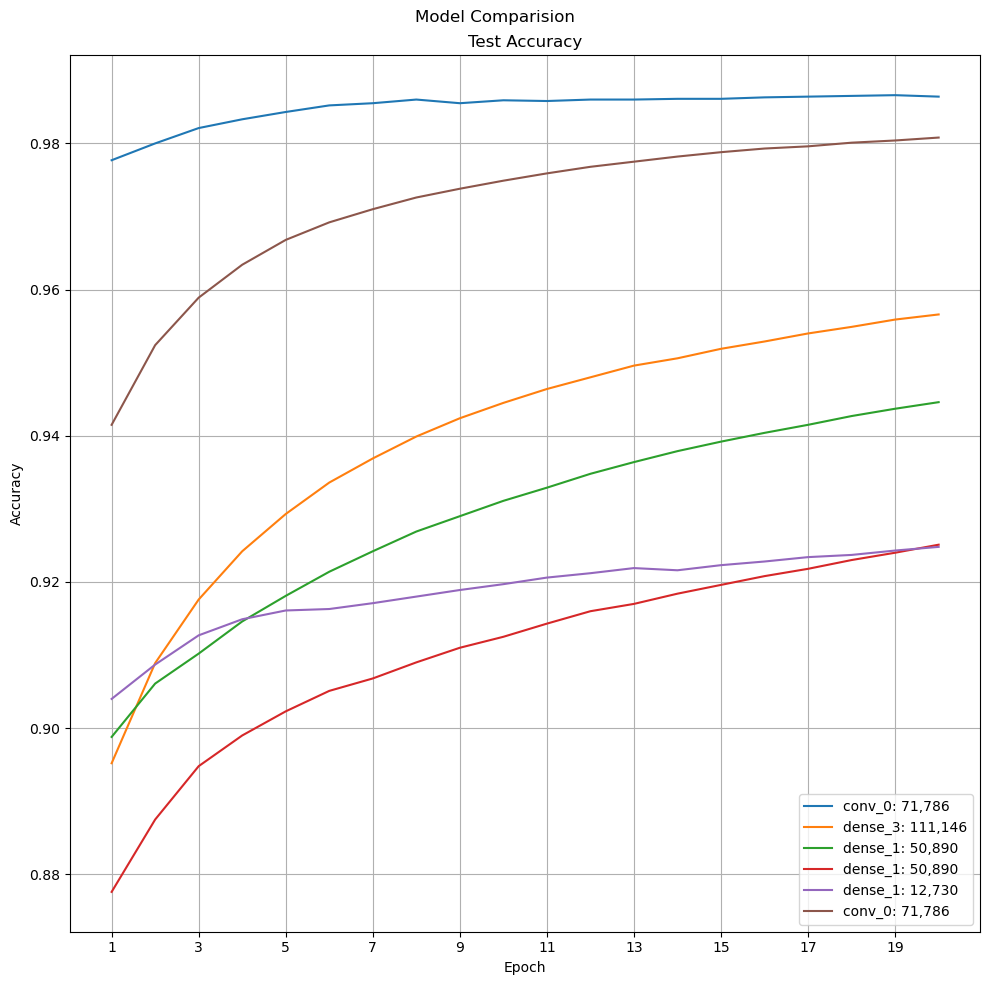

,model,layers,#params,lr,momentum,mini_batch,epochs,optimizer,accuracy_test,accuracy_train
0,CNN_2Conv_2MaxPool_1Dense,[],71786,0.010,0.9,512,20,Adam,0.9864,0.9887
5,CNN_2Conv_2MaxPool_1Dense,[],71786,0.010,0.9,512,20,SGD,0.9808,0.9737
1,Dense_3,"[128, 64, 32]",111146,0.010,0.9,512,20,SGD,0.9566,0.9530
2,Dense_1,[64],50890,0.010,0.5,128,20,SGD,0.9446,0.9403
3,Dense_1,[64],50890,0.010,0.5,256,20,SGD,0.9251,0.9172
4,Dense_1,[16],12730,0.001,0.9,64,20,Adam,0.9248,0.9241


In [70]:
# models_path = "./epochs_10/"
# models_path = "./epochs_20/"
# models_path = "./epochs_10_no_scheduler/"
models_path = "./epochs_20_no_scheduler/"

models_files = ["metrics_00.json","metrics_01.json",
                    "metrics_02.json", "metrics_03.json",
                    "metrics_04.json", "metrics_05.json",
                    "metrics_06.json", "metrics_07.json",
                    "metrics_08.json", "metrics_09.json",
                    "metrics_10.json", "metrics_11.json"]
models_files = [models_files[i] for i in MODELS_IDX + [1]]

models_to_compare = [models_path + model for model in models_files] # add the path to the models
df = compare_models(models_to_compare, plot=True)
df


